# Summary

# Initialization

In [25]:
import numpy as np
import utils.mnist_reader as mnist_reader
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.utils.data as D

import tqdm.notebook as tqdm
from sklearn.metrics import log_loss, roc_auc_score

from pathlib import Path
import time

#!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

import torchvision.models as models
import albumentations as A
from PIL import Image

In [2]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(1000)

In [3]:
PATH = Path("C:\StudioProjects\Fashion")

In [4]:
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

# EDA

In [5]:
X_train.shape

(60000, 784)

In [6]:
pd.value_counts(y_train)

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

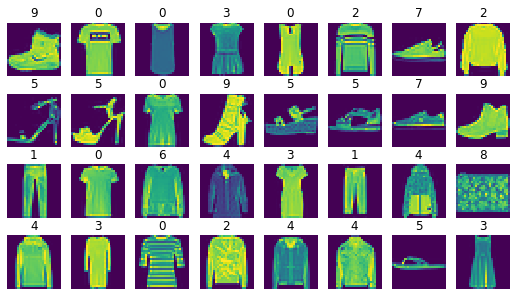

In [7]:
fig, axes = plt.subplots(4, 8, figsize=(9, 5))
for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    ax.set_title(y_train[i])
    ax.imshow(X_train[i].reshape(28,28))

In [52]:
classes = {
0:'T-shirt/top',
1:'Trouser',
2:'Pullover',
3:'Dress',
4:'Coat',
5:'Sandal',
6:'Shirt',
7:'Sneaker',
8:'Bag',
9:'Ankle boot'}

# Model

In [8]:
VERSION = 0

num_classes = 10
device = 'cuda'

model_name = "resnet18"
# model_name = "efficientnet-b0"
# model_name = "mobilenet_v2"

In [63]:
def getModel(model_name):
    
    if model_name == "efficientnet-b0":
        model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes)
    if model_name == "resnet18":
        model = models.resnet18(pretrained=False, num_classes=num_classes)
    if model_name == "mobilenet_v2":
        model = models.mobilenet_v2(num_classes=num_classes)

    model.cuda()

    if model_name == "resnet18":
        weights_path = 'https://download.pytorch.org/models/resnet18-5c106cde.pth'
    if model_name == "mobilenet_v2":
        weights_path = 'https://download.pytorch.org/models/mobilenet_v2-b0353104.pth'

    state_dict = models.utils.load_state_dict_from_url(weights_path)
    
    if model_name == "resnet18":
        state_dict['fc.weight'] = state_dict['fc.weight'][:num_classes]
        state_dict['fc.bias'] = state_dict['fc.bias'][:num_classes]
    if model_name == "mobilenet_v2":
        state_dict['classifier.1.weight'] = state_dict['classifier.1.weight'][:num_classes]
        state_dict['classifier.1.bias'] = state_dict['classifier.1.bias'][:num_classes]
    
    model.load_state_dict(state_dict)
    
    return model

In [11]:
X_mean = X_train.mean()
X_std = X_train.std()

In [12]:
class ImagesDS(D.Dataset):
    
    transforms1 = A.Compose([
        A.ShiftScaleRotate(p=0.5, shift_limit=0.0625, scale_limit=0.1, rotate_limit=0, border_mode=0),
        A.RandomBrightnessContrast(p=0.5, brightness_limit=0.2, contrast_limit=0.2),
    ])
    transforms2 = A.HorizontalFlip(p=0.5)
    
    def __init__(self, X, y, mode='train', use_transforms=False):
        
        self.X = X
        self.y = y.astype("int64")
        self.mode = mode
        self.use_transforms = use_transforms
        
        super(ImagesDS, self).__init__()
    
    def __getitem__(self, index):
        
        img = self.X[index].reshape(28,28)
        target = self.y[index]
        
        if self.use_transforms:
            ImagesDS.transform(img, target)
        
        img = (img - X_mean) / X_std
        img = np.broadcast_to(img,(3,28,28))
        
        img = torch.FloatTensor(img)
        
        return img, target
    
    def __len__(self):
        return len(self.y)
    
    @staticmethod
    def transform(X,y):
        Z = ImagesDS.transforms1(image=X)['image']
        if y in [0,1,2,3,4,6,8]:
            Z = ImagesDS.transforms2(image=Z)['image']
        return Z

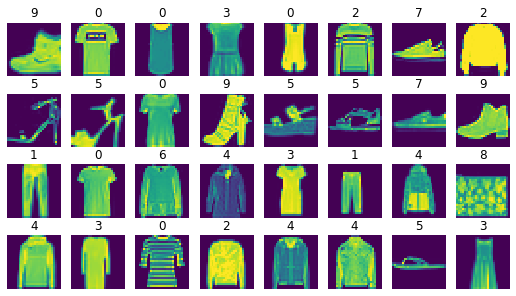

In [13]:
fig, axes = plt.subplots(4, 8, figsize=(9, 5))
for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    ax.set_title(y_train[i])
    ax.imshow(ImagesDS.transform(X_train[i].reshape(28,28), y_train[i]))

# Training

In [61]:
def runModel(model_name):

    model = getModel(model_name)

    bs = 64
    learning_rate = 1e-4
    use_transforms = False

    for epoch in range(7):

        if epoch == 3:
            learning_rate = 1e-5
        if epoch == 4:
            bs = 256
        if epoch == 5:
            use_transforms = True

        ds = ImagesDS(X_train, y_train, mode='train', use_transforms=use_transforms)
        ds_test = ImagesDS(X_test, y_test, mode='test')

        loader = D.DataLoader(ds, num_workers=0, batch_size=bs, shuffle=True)
        loader_test = D.DataLoader(ds_test, num_workers=0, batch_size=bs, shuffle=False)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # TRAIN

        train_ll = 0
        train_auc = 0
        train_acc = 0
        train_cnt = 0
        
        model.train()

        st = time.time()
        for x, y in tqdm.tqdm(loader):

            y_numpy = np.array(y)

            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            out_numpy = torch.softmax(out, 1).cpu().detach().numpy()

            cnt = len(y_numpy)
            train_ll += cnt*log_loss(y_numpy, out_numpy, labels=range(num_classes))
            train_auc += cnt*roc_auc_score(y_numpy, out_numpy, multi_class='ovo', labels=range(num_classes))
            train_acc += (y_numpy == out_numpy.argmax(1)).sum()
            train_cnt += cnt

            del x,y,loss,out

        train_time = time.time() - st

        train_ll /= train_cnt
        train_auc /= train_cnt
        train_acc /= train_cnt

        # TEST

        test_ll = 0
        test_auc = 0
        test_acc = 0
        test_cnt = 0
        
        model.eval()

        st = time.time()
        for x, y in tqdm.tqdm(loader_test):

            y_numpy = np.array(y)

            x = x.to(device)
            out = model(x)

            out_numpy = torch.softmax(out, 1).cpu().detach().numpy()

            cnt = len(y_numpy)
            test_ll += cnt*log_loss(y_numpy, out_numpy, labels=range(num_classes))
            test_auc += cnt*roc_auc_score(y_numpy, out_numpy, multi_class='ovo', labels=range(num_classes))
            test_acc += (y_numpy == out_numpy.argmax(1)).sum()
            test_cnt += cnt

            del x,y,out

        valid_time = time.time() - st

        test_ll /= test_cnt
        test_auc /= test_cnt
        test_acc /= test_cnt

        # SAVING STATS

        epoch_stats = pd.DataFrame([[VERSION, model_name, epoch, train_ll, train_auc, train_acc, 
                                     test_ll, test_auc, test_acc, bs, learning_rate, use_transforms, 
                                     train_time, valid_time]],
                                   columns = 
                                    ['ver','model_name','epoch','train_loss','train_auc','train_acc',
                                     'test_loss','test_auc','test_acc','bs','lr','augmented','train_time','test_time'
                                     ])

        stats_filename = PATH/'stats'/'stats.v{}'.format(VERSION)
        if stats_filename.is_file():
            epoch_stats = pd.concat([pd.read_csv(stats_filename), epoch_stats], sort=False)
        epoch_stats.to_csv(stats_filename, index=False)
        
    return model

In [35]:
model = runModel("resnet18")

In [15]:
pd.read_csv(stats_filename)

,ver,model_name,epoch,train_loss,train_auc,train_acc,test_loss,test_auc,test_acc,bs,lr,augmented,train_time,test_time
0,0,resnet18,0,0.482658,0.980858,0.835283,0.342482,0.990467,0.8784,64,0.00010,False,222.415762,11.786091
1,0,resnet18,1,0.285985,0.993788,0.896733,0.293274,0.992947,0.8941,64,0.00010,False,340.034750,12.440725
2,0,resnet18,2,0.232883,0.995523,0.916567,0.268745,0.994002,0.9051,64,0.00010,False,355.780394,12.895836
3,0,resnet18,3,0.155022,0.997724,0.943017,0.237703,0.995037,0.9165,64,0.00001,False,357.263989,14.590173
4,0,resnet18,4,0.118021,0.998482,0.957083,0.222569,0.995583,0.9244,256,0.00001,False,203.229534,6.278355
5,0,resnet18,5,0.107284,0.998731,0.960200,0.229875,0.995528,0.9229,256,0.00001,True,207.485522,6.294284
6,0,resnet18,6,0.097466,0.998930,0.963483,0.237851,0.995555,0.9241,256,0.00001,True,210.839171,6.664923


# Testing on a photo

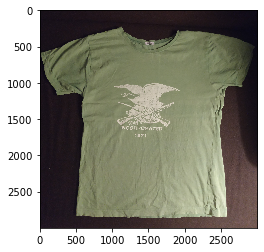

In [39]:
im = Image.open('tshirt.jpg')
plt.imshow(im)

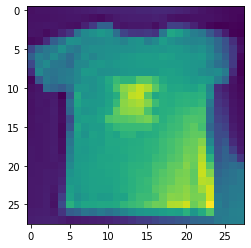

In [41]:
im = im.resize((28, 28), Image.ANTIALIAS)
im = np.array(im).mean(2)
plt.imshow(im)

In [42]:
im = (im - X_mean) / X_std
im = np.broadcast_to(im,(3,28,28))
im = torch.FloatTensor(im)

In [48]:
model.eval()
out = model(im.unsqueeze(0).cuda())
probs = torch.softmax(out, 1).cpu().detach().numpy()

In [57]:
pd.DataFrame({'class':[classes[i] for i in range(num_classes)], 'probability': probs[0]})

,class,probability
0,T-shirt/top,0.663816
1,Trouser,0.000018
2,Pullover,0.002892
3,Dress,0.001570
4,Coat,0.000301
5,Sandal,0.000025
6,Shirt,0.330763
7,Sneaker,0.000004
8,Bag,0.000581
9,Ankle boot,0.000031


# Running MobileNet-v2

In [64]:
runModel("mobilenet_v2")

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [69]:
stats = pd.read_csv(stats_filename)
stats

,ver,model_name,epoch,train_loss,train_auc,train_acc,test_loss,test_auc,test_acc,bs,lr,augmented,train_time,test_time
0,0,resnet18,0,0.482658,0.980858,0.835283,0.342482,0.990467,0.8784,64,0.00010,False,222.415762,11.786091
1,0,resnet18,1,0.285985,0.993788,0.896733,0.293274,0.992947,0.8941,64,0.00010,False,340.034750,12.440725
2,0,resnet18,2,0.232883,0.995523,0.916567,0.268745,0.994002,0.9051,64,0.00010,False,355.780394,12.895836
3,0,resnet18,3,0.155022,0.997724,0.943017,0.237703,0.995037,0.9165,64,0.00001,False,357.263989,14.590173
4,0,resnet18,4,0.118021,0.998482,0.957083,0.222569,0.995583,0.9244,256,0.00001,False,203.229534,6.278355
5,0,resnet18,5,0.107284,0.998731,0.960200,0.229875,0.995528,0.9229,256,0.00001,True,207.485522,6.294284
6,0,resnet18,6,0.097466,0.998930,0.963483,0.237851,0.995555,0.9241,256,0.00001,True,210.839171,6.664923
7,0,mobilenet_v2,0,0.667031,0.969607,0.779350,0.382305,0.987399,0.8637,64,0.00010,False,204.783493,12.734146
8,0,mobilenet_v2,1,0.365728,0.990264,0.870133,0.305555,0.992148,0.8912,64,0.00010,False,250.664515,13.443682
9,0,mobilenet_v2,2,0.279249,0.993894,0.899183,0.271010,0.993433,0.9048,64,0.00010,False,256.610601,13.659105


In [71]:
stats.loc[stats.model_name == 'resnet18'].train_time.sum() / 60

31.61748538017273

In [72]:
stats.loc[stats.model_name == 'mobilenet_v2'].train_time.sum() / 60

22.55093276500702